In [ ]:
# 导入数据预处理、模型训练和深度学习所需的库
# Import libraries for data preprocessing, model training, and deep learning
# データの前処理、モデルの訓練、そして深層学習に必要なライブラリをインポート

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# 读取训练和测试数据，并删除不需要的列
# Read training and testing data, and drop unnecessary columns
# トレーニングデータとテストデータを読み込み、不要な列を削除する

df_train = pd.read_csv('./train.csv', header=0)
df_train = df_train.drop(columns=['Unnamed: 0', 'id'])
df_test = pd.read_csv('./test.csv', header=0)
df_test = df_test.drop(columns=['Unnamed: 0', 'id'])

In [ ]:
# 计算并输出训练和测试数据集中的缺失值数量
# Calculate and output the number of missing values in the training and testing datasets
# トレーニングデータとテストデータにおける欠損値の数を計算して出力する

total_nan_train = df_train.isnull().sum().sum()
print("NaN in Train.csv:", total_nan_train)
total_nan_test = df_test.isnull().sum().sum()
print("NaN in Test.csv:", total_nan_test)

NaN in Train.csv: 310
NaN in Test.csv: 83


In [ ]:
# 对训练和测试数据进行预处理，包括数值特征的填充和标准化，以及类别特征的独热编码
# Preprocess the training and testing data, including imputing and scaling numerical features, and one-hot encoding categorical features
# トレーニングデータとテストデータを前処理し、数値特徴量の補完と標準化、カテゴリ特徴量のワンホットエンコーディングを行う

X_Tmp = df_train.drop(columns=["satisfaction"]) 
y_Tmp = df_train["satisfaction"]
X_Test = df_test.drop(columns=["satisfaction"])             
y_Test =  df_test["satisfaction"]

num_features = X_Tmp.select_dtypes(include=['float64', 'int64']).columns
cat_features = X_Tmp.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)

X_Train = preprocessor.fit_transform(X_Tmp)
x_test = preprocessor.transform(X_Test)

label_encoder = LabelEncoder()
y_Train = label_encoder.fit_transform(y_Tmp)
y_test = label_encoder.fit_transform(y_Test)


Age: -0.0144
Flight Distance: 0.0011
Inflight wifi service: 0.0893
Departure/Arrival time convenient: -0.0246
Ease of Online booking: -0.0564
Gate location: 0.0052
Food and drink: -0.0061
Online boarding: 0.1073
Seat comfort: 0.0106
Inflight entertainment: 0.0217
On-board service: 0.0447
Leg room service: 0.0434
Baggage handling: 0.0196
Checkin service: 0.0467
Inflight service: 0.0167
Cleanliness: 0.0329
Departure Delay in Minutes: 0.0187
Arrival Delay in Minutes: -0.0381
Gender_Male: 0.0071
Customer Type_disloyal Customer: -0.3084
Type of Travel_Personal Travel: -0.3806
Class_Eco: -0.1278
Class_Eco Plus: -0.1427


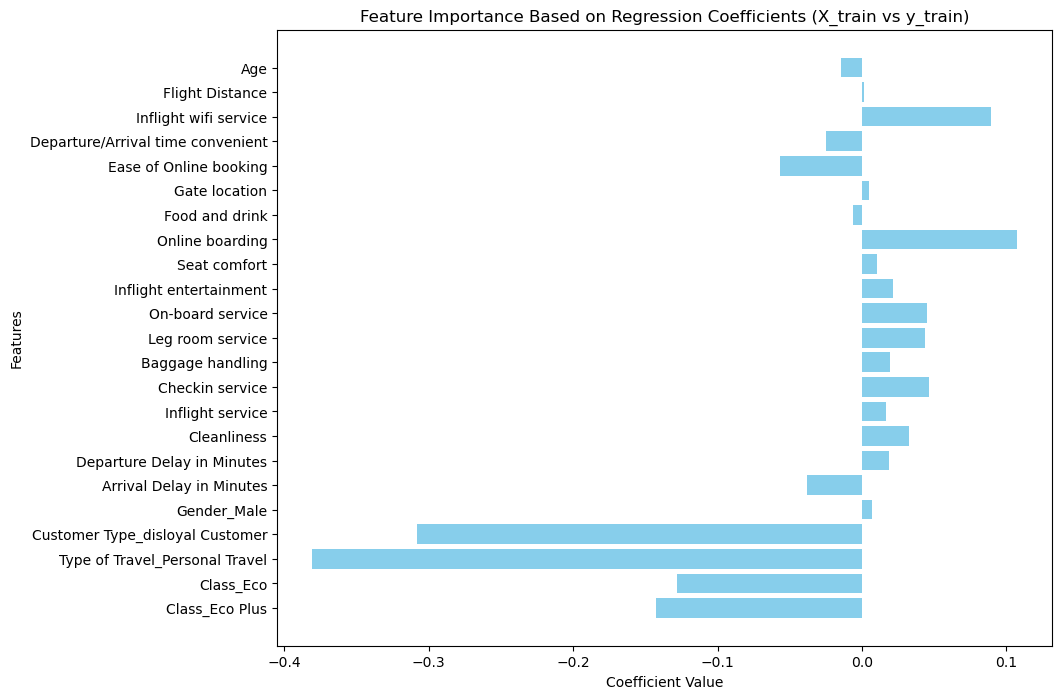

In [ ]:
# 训练线性回归模型，输出特征系数并可视化特征重要性
# Train a linear regression model, output feature coefficients, and visualize feature importance
# 線形回帰モデルを訓練し、特徴量の係数を出力し、特徴量の重要性を視覚化する

regressor = LinearRegression()
regressor.fit(X_Train, y_Train)

num_feature_names = num_features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

coefficients = regressor.coef_

for feature, coef in zip(all_feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

plt.figure(figsize=(10, 8))
plt.barh(all_feature_names, coefficients, color='skyblue')
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Feature Importance Based on Regression Coefficients (X_train vs y_train)")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# 将训练和验证数据集转换为 PyTorch 张量，并创建数据加载器
# Convert training and validation datasets to PyTorch tensors and create data loaders
# トレーニングデータと検証データをPyTorchテンソルに変換し、データローダーを作成する

x_train, x_val, y_train, y_val = train_test_split(X_Train, y_Train, stratify=y_Train, test_size=0.3)

X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# 定义一个包含三个全连接层、ReLU激活函数和Dropout的神经网络模型
# Define a neural network model with three fully connected layers, ReLU activation, and Dropout
# 全結合層、ReLU活性化関数、およびドロップアウトを含むニューラルネットワークモデルを定義する

class NeuralNetwork(nn.Module):
    def __init__(self, n_in, n_out):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(n_in, 64)
        self.l2 = nn.Linear(64,32) 
        self.l3 = nn.Linear(32, n_out)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dropout(x)
        x = self.relu(self.l2(x))
        x = self.dropout(x)
        x = self.l3(x)
        return x

In [ ]:
# 初始化神经网络模型，定义损失函数和优化器
# Initialize the neural network model, define the loss function, and the optimizer
# ニューラルネットワークモデルを初期化し、損失関数と最適化器を定義する

input_size = x_train.shape[1]
output_size = 2
model = NeuralNetwork(input_size, output_size)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 训练神经网络模型，并计算验证集准确率
# Train the neural network model and calculate validation accuracy
# ニューラルネットワークモデルを訓練し、検証精度を計算する

n_epochs = 100

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model.eval()
    val_accuracy = 0.0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_outputs = model(val_x)
            _, val_predicted = torch.max(val_outputs, 1)
            val_accuracy += (val_predicted == val_y).float().sum().item()
    
    val_accuracy /= len(val_dataset) 
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {train_loss/len(train_loader):.4f}, Val Accuracy: {val_accuracy*100:.2f}%')

Epoch [10/100], Loss: 0.1131, Val Accuracy: 95.78%
Epoch [20/100], Loss: 0.1033, Val Accuracy: 95.99%
Epoch [30/100], Loss: 0.0999, Val Accuracy: 96.05%
Epoch [40/100], Loss: 0.0976, Val Accuracy: 96.23%
Epoch [50/100], Loss: 0.0974, Val Accuracy: 96.09%
Epoch [60/100], Loss: 0.0949, Val Accuracy: 96.20%
Epoch [70/100], Loss: 0.0945, Val Accuracy: 96.05%
Epoch [80/100], Loss: 0.0940, Val Accuracy: 96.07%
Epoch [90/100], Loss: 0.0931, Val Accuracy: 96.17%
Epoch [100/100], Loss: 0.0931, Val Accuracy: 96.10%


In [ ]:
# 将测试数据转换为PyTorch张量
# Convert the test data to PyTorch tensors
# テストデータをPyTorchテンソルに変換する

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# 在测试集上评估模型的准确率
# Evaluate the model accuracy on the test set
# テストセットでモデルの精度を評価する

model.eval()
with torch.no_grad():
    test_outputs = model(x_test)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = (test_predicted == y_test).float().mean().item()
    print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Test Accuracy: 96.25%
